In [5]:
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [17]:
dev_data = pd.read_csv("Dev_data_to_be_shared.csv")
validation_data = pd.read_csv("validation_data_to_be_shared.csv")
# Store the 'account_number' separately before dropping it
account_number = validation_data['account_number']
# Columns to drop
columns_to_drop = [
    'bureau_enquiry_17', 'bureau_16', 'bureau_38', 'bureau_enquiry_37', 'bureau_182', 'bureau_282',
    'bureau_120', 'bureau_142', 'bureau_362', 'bureau_242', 'bureau_162', 'bureau_382', 'bureau_262',
    'bureau_322', 'bureau_202', 'bureau_100', 'bureau_342', 'onus_attribute_28', 'bureau_56', 'bureau_222',
    'bureau_302', 'bureau_423', 'bureau_402', 'bureau_80', 'bureau_enquiry_7', 'bureau_4', 'bureau_26',
    'bureau_enquiry_27', 'bureau_47', 'bureau_enquiry_47', 'bureau_292', 'bureau_172', 'bureau_392',
    'bureau_192', 'bureau_131', 'bureau_252', 'bureau_110', 'bureau_352', 'bureau_272', 'bureau_152',
    'bureau_372', 'bureau_212', 'bureau_312', 'bureau_232', 'bureau_332', 'bureau_412', 'bureau_90', 'bureau_70', 'account_number'
]

# Drop specified columns
dev_data.drop(columns=columns_to_drop, axis=1, errors='ignore', inplace=True)
validation_data.drop(columns=columns_to_drop, axis=1, errors='ignore', inplace=True)

# Drop columns with all missing values
dev_data.dropna(axis=1, how="all", inplace=True)
validation_data.dropna(axis=1, how="all", inplace=True)

# Separate target variable from features
X_dev = dev_data.drop(columns=["bad_flag"])
y_dev = dev_data["bad_flag"]

# Handle missing values by imputing with median
imputer = SimpleImputer(strategy="median")
X_dev_imputed = pd.DataFrame(imputer.fit_transform(X_dev), columns=X_dev.columns)
validation_data_imputed = pd.DataFrame(imputer.transform(validation_data), columns=validation_data.columns)

# Add the target column back to the development data
dev_data_imputed = X_dev_imputed.copy()
dev_data_imputed["bad_flag"] = y_dev.reset_index(drop=True)

# Define features and target
X = dev_data_imputed.drop(columns=['bad_flag'], axis=1)
y = dev_data_imputed['bad_flag']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.035, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42, n_estimators=101, class_weight='balanced')
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [18]:
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=8))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.8f}")
# Store the 'account_number' separately before dropping it
# Step 2: Prepare validation data
validation_X = validation_data_imputed.drop(columns=['bad_flag'], axis=1, errors='ignore')  # Ensure alignment
validation_X_scaled = scaler.transform(validation_X)

# Predict probabilities for validation data
validation_pred_proba = model.predict_proba(validation_X_scaled)[:, 1]

# Save the results
if 'account_number' in validation_data.columns:
    validation_data['predicted_probability'] = validation_pred_proba
    validation_data[['account_number', 'predicted_probability']].to_csv(
        "validation_predictions.csv", index=False
    )
else:
    validation_data_imputed['predicted_probability'] = validation_pred_proba
    validation_data_imputed.to_csv("validation_predictions.csv", index=False)

print("Validation predictions saved as 'validation_predictions.csv'.")

# Step 3: Save the trained model
joblib.dump(model, 'random_forest_model.pkl')

print("Model saved as 'random_forest_model.pkl'.")

Classification Report:
              precision    recall  f1-score   support

           0  0.98995434 0.99969259 0.99479963      3253
           1  0.99970554 0.99037340 0.99501758      3428

    accuracy                      0.99491094      6681
   macro avg  0.99482994 0.99503299 0.99490861      6681
weighted avg  0.99495765 0.99491094 0.99491146      6681

ROC AUC Score: 0.99985975
Validation predictions saved as 'validation_predictions.csv'.
Model saved as 'random_forest_model.pkl'.


In [19]:
# Drop 'account_number' and 'bad_flag' since they were excluded during training
validation_X_imputed = validation_data_imputed.drop(columns=['bad_flag'], axis=1, errors='ignore')

# Reindex to match training columns, ensuring proper column alignment
validation_X_imputed = validation_X_imputed.reindex(columns=X.columns, fill_value=0)

# Standardize the validation set using the same scaler
validation_X_scaled = scaler.transform(validation_X_imputed)

# Convert to DataFrame to retain column names
validation_X_scaled_df = pd.DataFrame(validation_X_scaled, columns=X.columns)

# Predict probabilities
validation_pred_proba = model.predict_proba(validation_X_scaled_df)[:, 1]

# Create a new DataFrame with 'account_number' and predictions
output_df = pd.DataFrame({
    'account_number': account_number,
    'predicted_probability': validation_pred_proba
})

# Save to CSV with 7 decimal precision
output_df.to_csv("validation_predictions.csv", index=False, float_format='%.7f')

print("Validation predictions saved as 'validation_predictions.csv'.")

c:\Users\donde\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Validation predictions saved as 'validation_predictions.csv'.


[[3252    1]
 [  33 3395]]


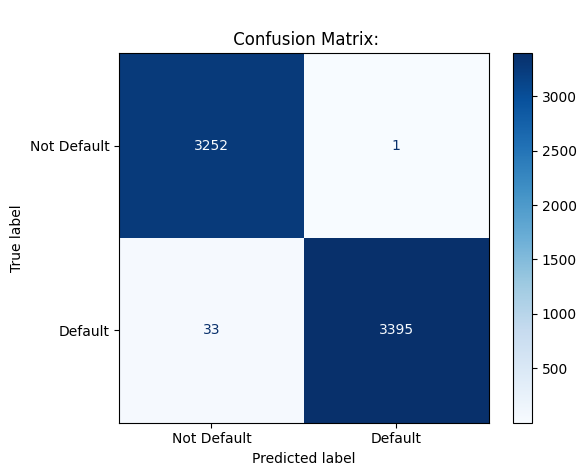

In [20]:
import matplotlib.pyplot as plt
cm= confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Default', 'Default'])
disp.plot(cmap='Blues', values_format='d')
plt.title('\n Confusion Matrix:')
print(cm)

In [21]:
model = joblib.load('random_forest_model.pkl')

In [22]:
dev_data = pd.read_csv("Dev_data_to_be_shared.csv")
def preprocess_data(data):
    data = data.drop(columns=columns_to_drop, errors='ignore')
    data = data.dropna(axis=1, how="all")
    imputer = SimpleImputer(strategy="median")
    data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
    return data_imputed

# Preprocess both datasets
dev_data = preprocess_data(dev_data)

# Split features and target
X_dev = dev_data.drop(columns=['bad_flag'], errors='ignore')
y_dev = dev_data['bad_flag']

# Standardize the data
scaler = StandardScaler()
X_dev_scaled = scaler.fit_transform(X_dev)

Classification Report on Dev Data:
              precision    recall  f1-score   support

         0.0    0.99965   0.99999   0.99982     95434
         1.0    0.99925   0.97595   0.98746      1372

    accuracy                        0.99965     96806
   macro avg    0.99945   0.98797   0.99364     96806
weighted avg    0.99965   0.99965   0.99965     96806

ROC AUC Score: 0.99994127


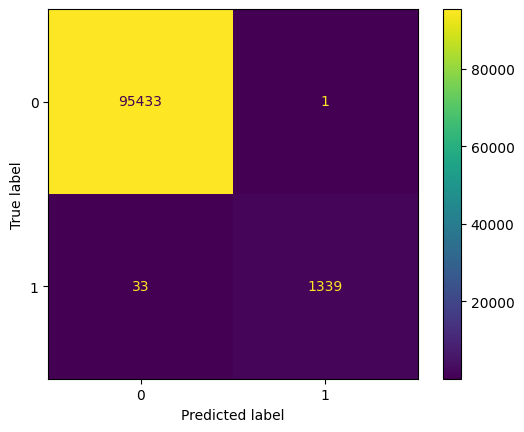

In [23]:
# 3. Testing on the entire dev data
y_dev_pred = model.predict(X_dev_scaled)
y_dev_pred_proba = model.predict_proba(X_dev_scaled)[:, 1]

# Evaluation on dev data
print("Classification Report on Dev Data:")
print(classification_report(y_dev, y_dev_pred,digits=5))
print(f"ROC AUC Score: {roc_auc_score(y_dev, y_dev_pred_proba):.8f}")
# Confusion Matrix
conf_matrix = confusion_matrix(y_dev, y_dev_pred)
ConfusionMatrixDisplay(conf_matrix).plot()